In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pymc3 as pm

%matplotlib inline 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 4.1 Inferring a Mean and Standard Deviation

/tmp/ipykernel_16/691687574.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6842969648763013, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


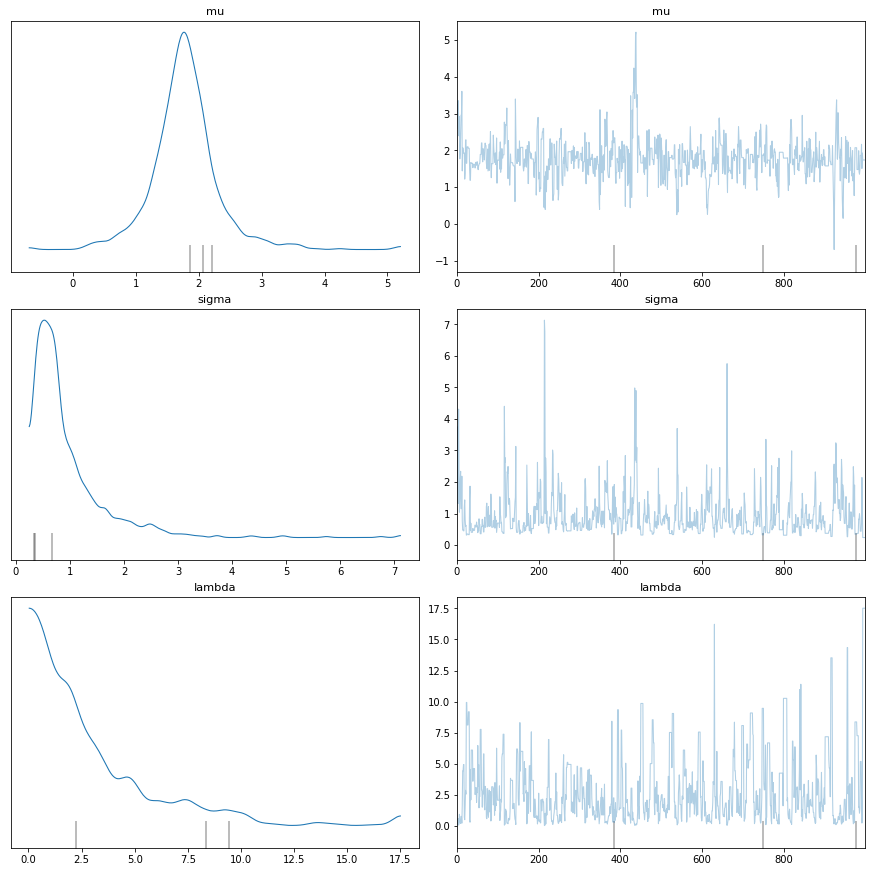

In [2]:
with pm.Model() as model:
    
    n_samples = 1000
    data = np.array([1.1, 1.9, 2.3, 1.8])
    
    # priors on mean and standard deviation
    mu = pm.Normal("mu", mu=0, tau=0.001)
    sigma = pm.Uniform("sigma", 0, 10)
    
    # deriving precision parameter
    tau = pm.Deterministic('lambda', 1/pm.math.sqr(sigma))
    
    obs = pm.Normal("obs", mu=mu, tau=tau, observed=data)
    
    trace = pm.sample(
        n_samples, 
        start={
            "mu": 0,
            "sigma": 1
        },
        chains=1,
    )

az.plot_trace(trace, figsize=(12, 12));

### 4.2 The Seven Scientists 

/tmp/ipykernel_16/654095147.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, mu]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


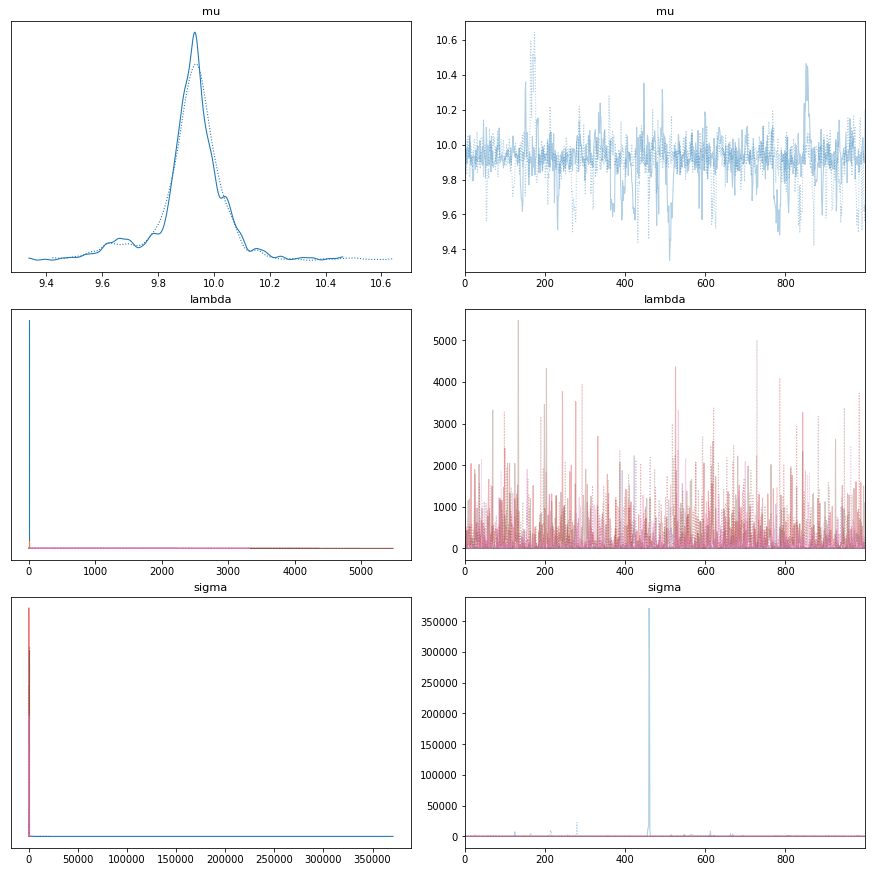

In [14]:
with pm.Model() as model:
    
    n_samples = 1000
    data = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
    
    # priors on mean and precision parameter
    mu = pm.Normal("mu", mu=0, tau=0.001)
    tau = pm.Gamma('lambda', alpha=0.001, beta=0.001, shape=data.shape)
    # standard deviation
    sigma = pm.Deterministic("sigma", 1/pm.math.sqrt(tau))
    
    obs = pm.Normal("obs", mu=mu, tau=tau, observed=data, shape=data.shape)
    
    trace = pm.sample(
        n_samples, 
        start={
            "mu": 0,
            "sigma": np.ones(data.shape)
        },
        chains=2,
        target_accept=0.95,
        tune=3000
    )

az.plot_trace(trace, figsize=(12, 12));

In [15]:
np.mean(trace['sigma'], axis=0), np.std(trace['sigma'], axis=0)

(array([5.38488940e+02, 3.40890098e+01, 7.26208525e+00, 4.86377921e-01,
        4.15377822e+00, 4.18856268e-01, 9.71411102e-01]),
 array([1.06308652e+04, 1.28646718e+02, 3.06452834e+01, 2.39316016e+00,
        8.10626461e+01, 1.64444742e+00, 5.45567331e+00]))

### 4.3  Repeated Measurement of IQ

/tmp/ipykernel_16/190394155.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_2, mu_1, mu_0, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


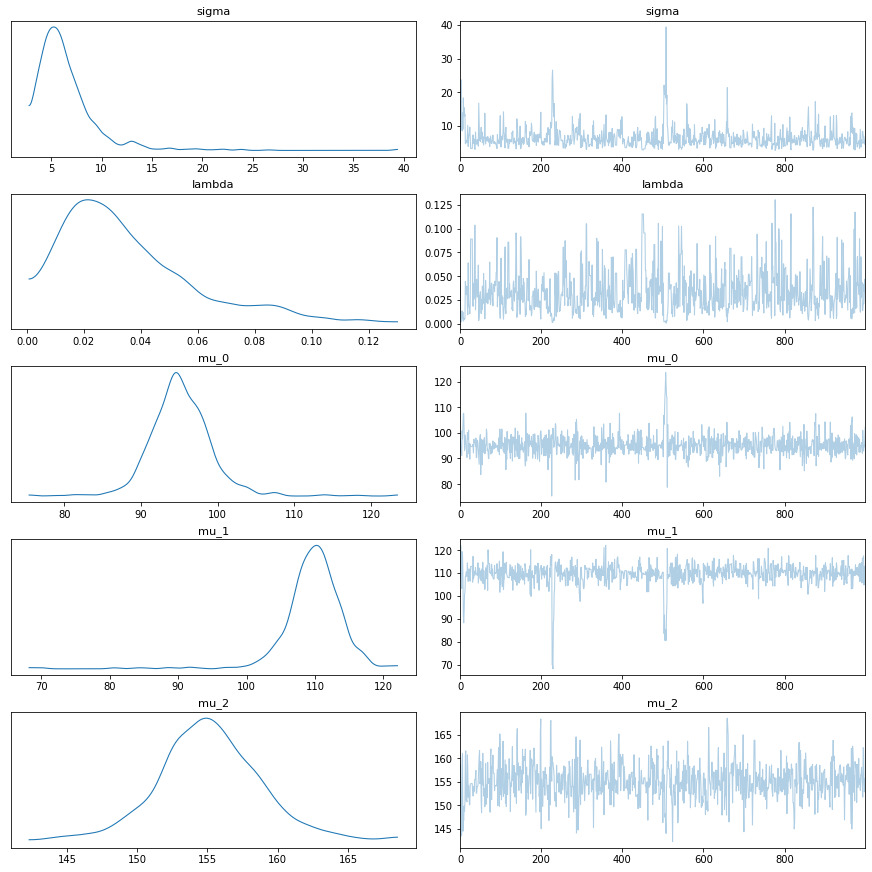

In [47]:
with pm.Model() as model:
    
    n_samples = 1000
    data = np.array([
        [90,95,100],
        [105,110,115],
        [150,155,160]
    ])
    # prior on the standard deviation
    sigma = pm.Uniform("sigma", lower=0, upper=100, testval=1)
    # deriving precision parameter
    tau = pm.Deterministic('lambda', 1/pm.math.sqr(sigma))
    
    # iterating over people
    for i in range(data.shape[0]):
        # priors on mean 
        mu = pm.Uniform(f"mu_{i}", lower=0, upper=300, testval=100)

        obs = pm.Normal(f"obs_{i}", mu=mu, tau=tau, observed=data[i, :])
    
    trace = pm.sample(
        n_samples, 
        chains=1,
    )

az.plot_trace(trace, figsize=(12, 12));
# az.plot_trace(trace, figsize=(12, 12));

In [50]:
np.mean(trace['mu_0'], axis=0), np.std(trace['mu_0'], axis=0)

(95.22685016979828, 4.075604988527082)

In [51]:
np.mean(trace['mu_1'], axis=0), np.std(trace['mu_1'], axis=0)

(109.5891647755937, 4.81603448371194)

In [52]:
np.mean(trace['mu_2'], axis=0), np.std(trace['mu_2'], axis=0)

(155.12722512535356, 3.791964959871697)